In [88]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from torch.optim import AdamW, Adam
from torch import autocast, GradScaler

from omegaconf import OmegaConf, open_dict

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from experanto.dataloaders import get_multisession_dataloader
from experanto.datasets import ChunkDataset

In [4]:
from experanto.configs import DEFAULT_CONFIG as cfg

In [266]:
cfg.dataset.global_chunk_size = 1
cfg.dataset.global_sampling_rate = 40
if "eye_tracker" in cfg.dataset.modality_config:
    with open_dict(cfg):
        del cfg.dataset.modality_config["eye_tracker"]
        del cfg.dataset.modality_config["treadmill"]

cfg.dataset.modality_config.screen.sample_stride = 1
cfg.dataset.modality_config.screen.include_blanks = False
cfg.dataset.modality_config.screen.include_blanks = False
cfg.dataset.modality_config.screen.interpolation.rescale = False
cfg.dataset.modality_config.responses.offset = 0.04
cfg.dataset.modality_config.screen.interpolation.rescale_size = None

In [267]:
root_path = "/data/monkey/pilot/experanto_datasets/dec5_first_try/"

In [268]:
from tqdm import tqdm

In [269]:
all_test_responses = []
for image_id in tqdm(ids_to_loop[:10]):
    cfg.dataset.modality_config.screen.valid_condition = dict(image_id=image_id.item(), valid_trial=True)
    
    dataset = ChunkDataset(root_path, **cfg.dataset)
    
    sample_points = np.where((np.diff(dataset._valid_screen_times)>1))[0]
    
    sample_points = np.insert(sample_points, 0,0)
    
    all_responses = []
    for i, s in enumerate(sample_points[:-1]):
        rs = []
        for j in range(s, sample_points[i+1]):
            rs.append(dataset[j]["responses"])
        all_responses.append(np.vstack(rs).mean(0))
    all_responses = np.stack(all_responses).mean(0)
    all_test_responses.append(all_responses)

100% 10/10 [04:42<00:00, 28.28s/it]


In [270]:
len(all_test_responses)

10

In [271]:
filename = "/data/monkey/pilot/datasets/CSRF19_V1_3814547587776.pickle"

In [272]:
import pickle
with open(filename, 'rb') as pkl:
    data = pickle.load(pkl)

In [273]:
testing_image_ids = data["testing_image_ids"]
testing_responses = data["testing_responses"]

In [274]:
testing_responses.shape

(317, 2265)

In [275]:
ids_to_loop = np.unique(testing_image_ids)[:25]

In [276]:
ids_to_loop

array([ 177,  208,  866,  898, 1149, 1262, 1483, 1695, 1774, 2605, 3035,
       3126, 3415, 3649, 3774, 3912, 3926, 4078, 4254, 4515, 4958, 5047,
       5095, 5118, 5235], dtype=uint32)

In [277]:
testing_responses.mean(1).argsort()

array([283, 206, 251, 285, 265,  40, 247, 207, 305,  55, 215, 114, 310,
       239, 316, 279, 115, 105, 266,  62, 128, 132, 197, 230, 233, 290,
        91, 245, 269, 189, 175,   5, 264, 253, 282, 180,  80, 109, 150,
       208, 261, 294, 224, 263, 203, 259,  16, 156, 309, 278, 225, 143,
         8,  22, 272,  76, 122,  14, 127,   7,  85, 307, 284, 257, 250,
       292, 118, 238, 107,  45, 106,   4, 121, 235, 274, 291,  89, 187,
        39,  94, 101, 102, 191, 252,   0, 296, 306,  92,  73, 100, 220,
        72, 201, 195, 137,  81, 270, 277,  90, 125, 194, 255, 138, 134,
       139, 183, 202, 281, 188, 144,  42, 249, 267,  31, 295, 271, 142,
        53,  82,  68, 254, 280, 258,  34, 176, 262, 209, 293,  23, 304,
       256, 133,  18,  19, 218, 120, 164, 314, 113,  79,   6, 308, 149,
        54, 214,  29, 219, 162,  33, 117, 287, 116, 151, 288, 148,  13,
       190,  38, 168, 155,  30, 157, 169, 160, 299,  58, 244,  56, 268,
       167,  49, 275,  78, 223, 260, 286, 248,  59, 289, 200, 31

In [299]:
neuron=64

In [300]:
neuron_means = []
for img_id in ids_to_loop[:10]:
    neuron_means.append(testing_responses[neuron, testing_image_ids == img_id].mean().item())

In [301]:
yo = [i[neuron].item() for i in all_test_responses]

In [302]:
20*8

160

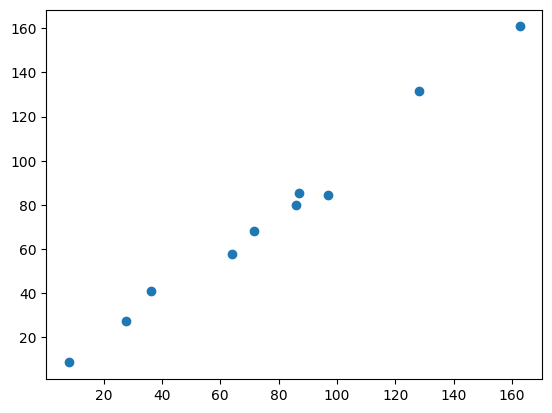

In [303]:
plt.scatter(np.array(yo)*1000, np.array(neuron_means) * (1000/120))

In [234]:
[i.mean().item() for i in testing_responses[88, testing_image_ids == 177]]

18.6